## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
818,1988,MINNESOTA,MN,27,41,33,US SENATE,statewide,gen,False,"HUBERT H. ""SKIP"" HUMPHREY III",DEMOCRATIC-FARMER-LABOR,False,total,856694,2093953,False,20210114,DEMOCRAT
2535,2010,ILLINOIS,IL,17,33,21,US SENATE,statewide,gen,True,NaN,NaN,True,total,19,3704473,False,20210114,OTHER
1888,2002,MISSISSIPPI,MS,28,64,46,US SENATE,statewide,gen,False,THAD COCHRAN,REPUBLICAN,False,total,533269,630495,False,20210114,REPUBLICAN
1917,2002,NORTH CAROLINA,NC,37,56,47,US SENATE,statewide,gen,False,ERSKINE B. BOWLES,DEMOCRAT,False,total,1047983,2331181,False,20210114,DEMOCRAT


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [6]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [18]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

In [27]:
len(senate_candidates_splitted)

439

**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [ ]:
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [12]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)


In [13]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')


In [14]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
445994,158094,2018-11-22-095291,What it means in effect is Republican leadersh...,Ted Cruz,[Q2036942],2018-11-22 04:03:22,1,"[[Ted Cruz, 0.7731], [None, 0.1521], [Kelly Ay...",[http://dailycaller.com/2015/09/24/ted-cruz-sa...,E,[com]
430304,142404,2018-01-23-020796,Don't ask me why I wore it or liked it. It had...,Kevin O'Connor,"[Q1740227, Q20716333, Q21467170, Q28672693, Q4...",2018-01-23 15:01:40,1,"[[Kevin O'Connor, 0.7938], [None, 0.2062]]",[https://www.joe.ie/fitness-health/kevin-oconn...,E,[ie]
137167,36617,2017-09-07-156646,What we're doing in this body today is not dra...,Ben Sasse,[Q16192221],2017-09-07 18:41:16,10,"[[Ben Sasse, 0.8836], [None, 0.0828], [Chuck S...",[https://www.nytimes.com/2017/09/07/us/politic...,E,"[com, com, com, net, com, com, com, com, com, ..."
326006,38106,2018-10-06-016433,I believe Judge Kavanaugh will be a justice wh...,Cindy Hyde-Smith,[Q5120540],2018-10-06 15:33:17,1,"[[Cindy Hyde-Smith, 0.614], [None, 0.3467], [R...",[http://yallpolitics.com/2018/10/06/kavanaugh-...,E,[com]


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [19]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['numOccurrences'].sum()
candidate_quotes_byday

speaker          date_only 
AARON JAMES      2016-02-18     6
                 2016-05-10     2
                 2016-05-12     2
                 2016-05-18    11
                 2016-05-25     2
                               ..
ZAK RINGELSTEIN  2018-10-30    12
                 2018-11-01     5
                 2018-11-05     1
                 2018-11-07     1
                 2019-03-21     1
Name: numOccurrences, Length: 79165, dtype: int64

Text(0.5, 1.0, 'Bernie Sanders')

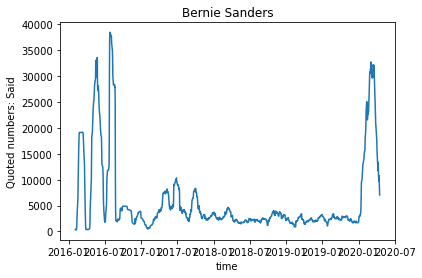

In [20]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [45]:
candidate_quotes['speaker'].map(candidate_info_byname['year'])

0         2016
1         2016
2         2016
3         2018
4         2016
          ... 
582923    2016
582924    2016
582925    2018
582926    2016
582927    2018
Name: speaker, Length: 582928, dtype: int64

In [21]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [22]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [23]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['numOccurrences'].sum())
tot_quotes_byelection.rename(columns = {'numOccurrences': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6411031053149663, p value: 3.200336954711353e-22


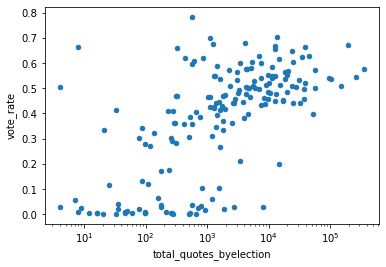

In [24]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [25]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [26]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
495459,2015-02-23-083824,We do have to go to voters to get funds [ for ...,None,[],2015-02-23 13:00:00,1,"[[None, 0.8931], [Mia Gregerson, 0.1069]]",[http://www.kplu.org/post/lawmakers-drop-bill-...,E,OTHER,[org]
461810,2017-09-06-022930,"Early on, I got sick. And, I thought it was ju...",Rodney King,[Q338389],2017-09-06 00:00:00,8,"[[Rodney King, 0.6826], [None, 0.3174]]",[http://apr.org/post/rural-health-being-jolted...,E,OTHER,"[org, org, org, org, org, org, org, org]"
213625,2019-02-03-059695,What you're insinuating is what nobody wants t...,Rep. Ilhan Omar,[Q26436159],2019-02-03 00:00:00,3,"[[Rep. Ilhan Omar, 0.5078], [None, 0.4922]]",[http://feeds.foxnews.com/~r/foxnews/politics/...,E,OTHER,"[com, us, com]"
835831,2017-08-13-005437,As the workers' latest claims appear to corrob...,Yeo Guat Kwang,[Q8052395],2017-08-13 20:10:49,1,"[[Yeo Guat Kwang, 0.8189], [None, 0.1811]]",[http://www.todayonline.com/singapore/two-fore...,E,OTHER,[com]


In [ ]:
# find the mentioned senator of each quotation 
# DO NOT RUN with the new Dataset!
senate_candidates = list(map(lambda x:x.title(), senate_candidates))
candidate_quotes_mention['mention']=candidate_quotes_mention['quotation'].map(lambda x:np.array(senate_candidates)[np.array(list(k in x for k in senate_candidates))][0])
candidate_quotes_mention.head(4)

In [32]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date

# filt out Other and Others
candidate_quotes_mention = candidate_quotes_mention[candidate_quotes_mention.mention!='OTHER']
candidate_quotes_mention = candidate_quotes_mention[candidate_quotes_mention.mention!='OTHERS']
candidate_quotes_mention = candidate_quotes_mention[candidate_quotes_mention.mention!='SCATTER']
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['numOccurrences'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-08-04    1
                  2015-12-11    2
                  2017-02-12    2
                  2017-05-28    1
                  2017-06-22    1
                               ..
WILLIE L. WILSON  2019-03-30    1
                  2019-07-16    1
                  2019-11-04    1
ZAK RINGELSTEIN   2018-06-22    1
                  2018-10-24    1
Name: numOccurrences, Length: 38705, dtype: int64

Text(0.5, 1.0, 'Bernie Sanders')

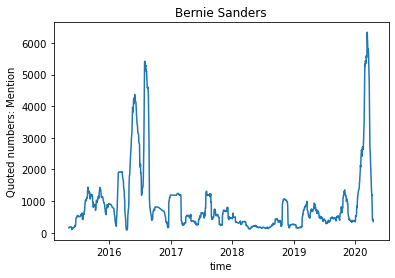

In [35]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [51]:
candidate_quotes_mention['mention'].map(candidate_info_byname['year']) # The bug comes from other uncleared name like 'blank vote'

52        2018.0
98        2018.0
176          NaN
240       2020.0
254       2016.0
           ...  
190804    2018.0
190810    2020.0
190832    2020.0
190841    2016.0
190856       NaN
Name: mention, Length: 103692, dtype: float64

In [ ]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

In [ ]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['numOccurrences'].sum())
tot_quotes_byelection.rename(columns = {'numOccurrences': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**A problem of QuoteBank noticed when parsing url**: some urls are list of list of urls, like: [['url_a', 'url_b'], 'url_c', 'url_d']

**2.1** First, we sample 20k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often.

In [22]:
# sample 20k quotes and see where published
sample = candidate_quotes.sample(20000)
total_domains = []
for i in sample.index:
    urls = sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        if isinstance(url, list):
            for url_ in url:
                total_domains.append(get_tld(url_, as_object=True).domain) # when it is a list, the multiply urls point to the same website
        else:
            total_domains.append(get_tld(url, as_object=True).domain)

**DONOT rerun the below two cells, in case the distribution changes!**

In [23]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


----top 30 news agency/publisher:
  [('krmg', 2173), ('news965', 1716), ('wokv', 1272), ('msn', 1234), ('breitbart', 1081), ('thehill', 1032), ('businessinsider', 1004), ('washingtonexaminer', 980), ('yahoo', 929), ('washingtontimes', 900), ('cnn', 845), ('einnews', 838), ('foxnews', 787), ('cbsnews', 756), ('wsbradio', 745), ('washingtonpost', 597), ('newsmax', 582), ('politico', 575), ('sfgate', 571), ('nbcnews', 532), ('nytimes', 506), ('huffingtonpost', 494), ('kdhnews', 474), ('startribune', 444), ('news12', 443), ('salon', 402), ('wftv', 400), ('abc-7', 396), ('rollcall', 379), ('indiatimes', 359)]
----number of news agency covered: 4246


Among 20k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

Text(0.5, 0, 'occurences in sampled quote data')

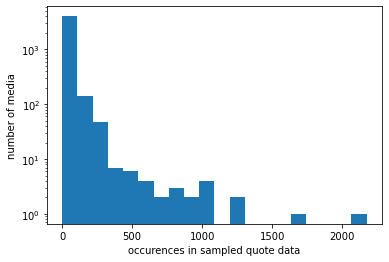

In [24]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

In [24]:
# Randomly sample 10 other media, to be used for estimating the rest readership
media_ind = np.random.randint(31, len(domain_count), size=10)
print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

10 randomly selected news agency/publisher except the top 30:
  [('localsyr', 117), ('theadanews', 4), ('metro', 113), ('greenfieldreporter', 6), ('newswest9', 160), ('politic365', 1), ('all4women', 3), ('wxxinews', 67), ('daijiworld', 3), ('pakobserver', 5)]


The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest.

In [53]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
weight_df # demonstrate the format of election data

,webdomain,agency,total_view_in_US,audience,source
0,KRMG,KRMG,0.11,0.033,https://webrate.org/site/krmg.com/
1,news965,WBDO,NaN,NaN,default
2,wokv,WOKV,0.09,0.046,https://webrate.org/site/wokv.com/
3,msn,MSN,323.98,194.400,default
4,breitbart,Breitbart,42.19,40.730,default
5,thehill,The Hill,42.07,23.000,default
6,businessinsider,Business Insider,58.93,53.250,default
7,washingtonexaminer,Washington Examiner,13.32,9.230,default
8,yahoo,Yahoo,85.03,17.900,https://cnnpressroom.blogs.cnn.com/2021/07/19/...
9,washingtontimes,Washington Times,3.77,2.960,default


In [54]:
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US', 'audience']] = weight_df[['total_view_in_US', 'audience']].fillna(weight_df[['total_view_in_US', 'audience']].median())
# Get the view for randomly selected agency
random_view = 0.2

In [55]:
# assign weights to quotes
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        if isinstance(url, list):
            for url_ in url:
                webdomain = get_tld(url_, as_object=True).domain # when it is a list, the multiply urls point to the same website
                if webdomain in weight_dict.keys():
                    weight_ = weight_ + weight_dict[webdomain]
                    n_hit = n_hit + 1
                else:
                    weight_ = weight_ + random_view
        else:
            webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
            if webdomain in weight_dict.keys():
                weight_ = weight_ + weight_dict[webdomain]
                n_hit = n_hit + 1
            else:
                weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_
print('we found {} numbers of quotation occurrences from top 30'.format(n_hit))

we found 585803 numbers of quotation occurrences from top 30


In [56]:
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,views
323197,35297,2018-11-06-033286,I don't really think that's any of your busine...,KYRSTEN SINEMA,[Q1556541],2018-11-06 17:11:02,1,"[[Kyrsten Sinema, 0.5842], [None, 0.4158]]",[https://heavy.com/news/2018/11/kyrsten-sinema...,E,[com],2018-11-06,2018-11-01,0.20
200927,100377,2017-09-10-053692,resort to innuendo and impugning my character,BERNIE SANDERS,[Q359442],2017-09-10 21:41:26,2,"[[Bernie Sanders, 0.4056], [None, 0.2948], [Hi...",[http://www.wnd.com/2017/09/hillary-gone-wild-...,E,"[com, com]",2017-09-10,2018-11-01,85.23
218549,117999,2017-10-29-077608,We need to get to the bottom of it and we need...,ROB PORTMAN,[Q926069],2017-10-29 00:00:00,20,"[[Rob Portman, 0.6633], [None, 0.3066], [Presi...",[http://nbcnews.com/politics/congress/sen-rob-...,E,"[com, com, com, com, com, com, com, com, com, ...",2017-10-29,2016-11-01,437.74
100633,83,2017-05-02-144407,What we need to do is bring forth a progressiv...,BERNIE SANDERS,[Q359442],2017-05-02 00:00:00,1,"[[Bernie Sanders, 0.665], [Frank Jackson, 0.22...",[http://radio.wosu.org/post/bernie-sanders-wei...,E,[org],2017-05-02,2018-11-01,0.20
81622,81622,2016-02-22-094046,The Official Candidate of the Son of God.,TED CRUZ,[Q2036942],2016-02-22 01:32:46,1,"[[Ted Cruz, 0.6767], [Jerry Falwell Jr. ., 0.2...",[http://www.chicagotribune.com/news/opinion/ch...,E,[com],2016-02-22,2018-11-01,0.20


**2.3** We repeat the protocol in section **1.2-1.4** to examine the effect of level of exposure on election results 

In [57]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['views'].sum()
candidate_views_byday

speaker          date_only 
AARON JAMES      2016-02-18    1.2
                 2016-05-10    0.4
                 2016-05-12    0.4
                 2016-05-18    2.2
                 2016-05-25    0.4
                              ... 
ZAK RINGELSTEIN  2018-10-30    2.4
                 2018-11-01    1.0
                 2018-11-05    0.2
                 2018-11-07    0.2
                 2019-03-21    0.2
Name: views, Length: 79165, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

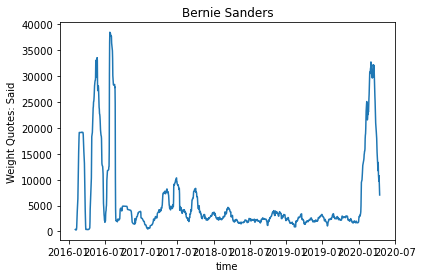

In [58]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [67]:
candidate_info_byname

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified,vote_rate
candidate,,,,,,,,,,,,,,,,,,,
RON CRUMPTON,2016,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,DEMOCRAT,False,total,748709,2087444,False,20210114,DEMOCRAT,0.358673
RICHARD C. SHELBY,2016,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,REPUBLICAN,False,total,1335104,2087444,False,20210114,REPUBLICAN,0.639588
JOE MILLER,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,LIBERTARIAN,False,total,90825,311441,False,20210114,LIBERTARIAN,0.291628
TED GIANOUTSOS,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,INDEPENDENT,False,total,1758,311441,False,20210114,OTHER,0.005645
RAY METCALFE,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,DEMOCRAT,False,total,36200,311441,False,20210114,DEMOCRAT,0.116234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MARK R. WARNER,2020,VIRGINIA,VA,51,54,40,US SENATE,statewide,gen,False,DEMOCRAT,False,total,2466500,4405087,False,20210114,DEMOCRAT,0.559921
DANIEL M. GADE,2020,VIRGINIA,VA,51,54,40,US SENATE,statewide,gen,False,REPUBLICAN,False,total,1934199,4405087,False,20210114,REPUBLICAN,0.439083
SHELLEY MOORE CAPITO,2020,WEST VIRGINIA,WV,54,55,56,US SENATE,statewide,gen,False,REPUBLICAN,False,total,547454,778918,False,20210114,REPUBLICAN,0.702839


In [62]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['views'].sum())
views_byelection.rename(columns = {'views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6374158513455435, p value: 6.542958980160349e-22


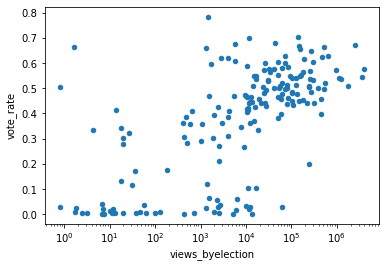

In [70]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

We notice very little change on the pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). Just applying the number of quotations is probably sufficient for clustering and prediction model.

## 3. Features for Prediction Model
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [25]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [27]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3441,2016,COLORADO,CO,8,84,62,US PRESIDENT,"MATUREN, MICHAEL A.",AMERICAN SOLIDARITY PARTY,False,862,2780220,20210113,NaN,OTHER
3580,2016,MISSOURI,MO,29,43,34,US PRESIDENT,NaN,NaN,True,7156,2808605,20210113,NaN,OTHER
3623,2016,NEW YORK,NY,36,21,13,US PRESIDENT,"TRUMP, DONALD J.",CONSERVATIVE,False,292392,7802084,20210113,NaN,OTHER
3530,2016,MAINE,ME,23,11,2,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,335593,771892,20210113,NaN,REPUBLICAN


In [28]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [29]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [30]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

In [31]:
features.sample(4)

,party_simplified,vote_rate,party_vote_rate
candidate,,,
RAY J. WRITZ,OTHER,0.061385,0.091421
PAUL STANTON,LIBERTARIAN,0.021174,0.021979
JOSH HAWLEY,REPUBLICAN,0.513832,0.567723
DEBORAH K. ROSS,DEMOCRAT,0.453657,0.461729


# 4. statistics of sentence complexity

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [32]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000


In [33]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000
